In [1]:
import wikipedia
wikipedia.set_lang('en') # setting wikipedia language
import wikipediaapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from time import sleep
import sys
import pageviewapi.period
from numpy import dot
from numpy.linalg import norm
import collections
import matplotlib.pyplot as plt
import networkx as nx
import zipfile

import nltk # for nlp on articles
#nltk.download("stopwords")
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# I. Data Acquisition

## Data Acquisition Utils

In [2]:
class DataAquisitionUtils():

    @staticmethod
    def fetch_category_members(category_members, level=0, max_level=1):
        """
        Function to take all article in category (max_level control the depth of articles taken from the subcategories)
        Arguments:
        category_members - a list of category members
        level - the level at which to start getting articles
        max_level - the maximal level for the fetched articles
        Returns:
        list_articles - a list of the desired articles
        """
        list_articles = []
        for c in category_members.values():
            if c.ns == 0:
                list_articles.append(c) 
                #print("%s: %s (ns: %d)" % ("*" * (level + 1), c.title, c.ns))
            elif level < max_level and c.ns == 14:
                sub_list = []
                sub_list = DataAquisitionUtils.fetch_category_members(c.categorymembers, level=level + 1, max_level=max_level)
                list_articles = list_articles + sub_list
        return list_articles

    @staticmethod
    def hyperlinks_matrix(list_articles):
        """
        Computes an adjacency matrix with the hyperlinks between the different articles in the argument given
        Arguments:
        list_articles - a list of articles for which to compute the hyperlink matrix
        Returns:
        matrix - a binary matrix A where A[i,j] = 1 if article i has a hyperlinkt to article j, and A[i,j] = 0 otherwise
        """
        len_time = len(list_articles)*0.05
        matrix = np.zeros((len(list_articles), len(list_articles)))
        compt = 0
        for article in list_articles:
            for link in article.links:
                for i in range(len(list_articles)):
                    if (link == list_articles[i].title):
                        matrix[compt,i] = 1
            compt = compt + 1
            sys.stdout.write('\r')
            sys.stdout.write("[%-20s] %d%%" % ('='*int(compt/len_time), int(5*compt/len_time)))
            sys.stdout.flush()
            sleep(0.25)
        return matrix
    
    @staticmethod
    def take_words(list_articles, stop_words, is_title = False):
        """
        Function that tokenizes and returns all words in the list of articles given
        Arguments:
        list_articles - list of articles
        is_title - whether the list contains pages or just strings of titles
        Returns:
        words_df - the words in the articles in a dataframe
        """
        len_time = len(list_articles)*0.05
        words_df = pd.DataFrame(columns=['article', 'words'])
        for i in range(len(list_articles)):
            try:
                if (is_title == False):
                    page = wikipedia.page(list_articles[i].title)
                else:
                    page = wikipedia.page(list_articles[i])
            except wikipedia.DisambiguationError as e:
                s = e.options
                s = list(filter(lambda x : x != "", s))
                try :
                    page = wikipedia.page(s)
                except wikipedia.DisambiguationError as e:
                    pass
            except wikipedia.PageError:
                pass
            words = word_tokenize(page.content)
            words = [elem.lower() for elem in words]
            words = [elem for elem in words if len(elem) > 1 and elem.isdigit() == False]
            words_wostop = [x for x in words if x not in stop_words]
            words_wostop = [elem.lower() for elem in words_wostop]
            if (is_title == False):
                words_df.loc[i] = [list_articles[i].title] + [words_wostop]
            else:
                words_df.loc[i] = [list_articles[i]] + [words_wostop]
            sys.stdout.write('\r')
            sys.stdout.write("[%-20s] %d%%" % ('='*int((i+1)/len_time), int(5*(i+1)/len_time)))
            sys.stdout.flush()
            sleep(0.25)
        return words_df
    
    @staticmethod
    def page_view(list_articles): 
        """
        Function to return the views for a list of wikipedia articles
        Arguments:
        list_articles - list of wikipedia articles
        Returns:
        view_df - a dataframe containing the views for the articles
        """
        len_time = len(list_articles)*0.05
        view_df = pd.DataFrame(columns=['article', 'views'])
        for i in range(len(list_articles)):
            try: 
                view_df.loc[i] = [list_articles[i].title] + [pageviewapi.period.sum_last('en.wikipedia', list_articles[i].title, last=30,
                        access='all-access', agent='all-agents')]
            except pageviewapi.client.ZeroOrDataNotLoadedException as e:
                view_df.loc[i] = 0
            except wikipedia.PageError:
                pass
            sys.stdout.write('\r')
            sys.stdout.write("[%-20s] %d%%" % ('='*int((i+1)/len_time), int(5*(i+1)/len_time)))
            sys.stdout.flush()
            sleep(0.25)
        return view_df

## NLP Utilities

In [3]:
class NLPUtilities():
    
    @staticmethod
    def TF_IDF(words_df, nb_words, has_mywords = False, *args, **kwargs):
        """
        Function to get the words with the top TF-IDF scores
        Arguments:
        words_df - the dataframe consisting of the words to be considered
        nb_words - the number of words we would like the function to return
        has_mywords - enables the use of words of significant importance, independently of their TF-IDF score
        Returns:
        df - a dataframe containing the words with the best TF-IDF scores
        """
        #remove strings like "10,000"
        #religion_df['words'] = religion_df['words'].apply(lambda word_list: list(filter(lambda word: (',' not in word), word_list)))
        #only keep strings that contain alphabet chars
        words_df['words'] = words_df['words'].apply(lambda word_list: list(filter(lambda word: word.isalpha(), word_list)))
        # create a column with all words concatenated
        words_df['words_string'] = words_df['words'].apply(lambda words_list: " ".join(words_list))

        cv=CountVectorizer()
        word_count_vector=cv.fit_transform(words_df['words_string'])

        tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
        tfidf_transformer.fit(word_count_vector)

        # count matrix
        count_vector=cv.transform(words_df['words_string'])

        # tf-idf scores
        tf_idf_vector=tfidf_transformer.transform(count_vector)

        feature_names = cv.get_feature_names()
        
        dense = tf_idf_vector.todense()
        denselist = dense.tolist()
                
        #tf_idf = matrix where rows are articles and columns are words and values are tfidf score for word in article
        tf_idf = pd.DataFrame(data=denselist, columns=feature_names, index=words_df['article'])
        
        if (has_mywords == False):
            #these are the words that have the biggest tfidf score
            important_words = pd.DataFrame(tf_idf.sum(axis=0, numeric_only=True).sort_values(ascending = False),\
                                      columns=['tfidf']).head(nb_words).index.values
        else:
            important_words = args[0]
        
        #only keep the most important words in matrix
        tf_idf = tf_idf[important_words]

        return tf_idf

## A. Fetching the articles of interest

We start off my fetching the articles belonging to the topics of interest: Science and Religion.

In [4]:
aquire = DataAquisitionUtils()

In [5]:
wiki_wiki = wikipediaapi.Wikipedia('en') # getting articles in english
# fetching the articles for categories of interest
religion_page = wiki_wiki.page("Category:Religion")
science_page = wiki_wiki.page("Category:Science")
religion_articles = aquire.fetch_category_members(religion_page.categorymembers)
science_articles = aquire.fetch_category_members(science_page.categorymembers)
list_articles = religion_articles + science_articles

## B. Hyperlink matrix

This is the adjacency matrix $H$ of the hyperlinks between articles. This means that if an article $A_{i}$ has a link to another article $A_{j}$, then $H_{ij} = 1$. 

In [6]:
zf = zipfile.ZipFile('hyperlinks.csv.zip') 
hyperlinks_df = pd.read_csv(zf.open('hyperlinks.csv'), header=None, sep = " ")

In [7]:
# EXECUTE IF YOU DO NOT HAVE CSV
#list_articles = religion_articles + science_articles
#hyperlinks = aquire.hyperlinks_matrix(list_articles)
#np.savetxt('hyperlinks.csv', adjacency_matrix)

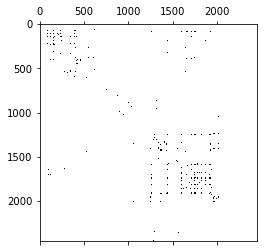

In [8]:
hyperlinks = hyperlinks_df.values
plt.spy(hyperlinks)

We can see that the hyperlink matrix is sparse. Hence, it seems unable illustrate the similarity between articles on its own. We will need to use another measure which we put in place later on.

## C. Number of views

We now construct a matrix containing the total number of views for articles for a period of 30 days.

In [9]:
views_df = pd.read_pickle('./views.pickle')

In [10]:
#Execute only if you don't have the pickles
#views_df = aquire.page_view(list_articles)

## D. Measuring article similarity through words

We construct a matrix to represent articles using their words. We select the most important words using their TF-IDF score. This gives a vector representation for each article, which we can use to measure similarity between articles.

In [11]:
#Take all the words present in the articles that are not stopwords
stop_found = ['====', '===', '==', '<<', '>>', "''", '``', "'s" , '\displaystyle', '...', '\phi', '\mu', '\mathbf', '--', 'x_',
        '\alpha', '\dot', '\hat', '\lambda', '\left', '\right', 'mathcal', '\nu', '\partial'] #getting the stopwords found in the articles after exmination
stop_pre = stopwords.words('english') # getting the common english stopwords
stop_words = stop_found + stop_pre

In [12]:
religion_df = pd.read_pickle('./religion_articles')
science_df = pd.read_pickle('./science_articles')
religion_df = religion_df.drop_duplicates('article')
science_df = science_df.drop_duplicates('article')

In [13]:
#Execute only if you don't have the pickles
#religion_df= aquire.take_words(religion_articles, stop_words)
#religion_df = religion_df.drop_duplicates('article')

In [14]:
#Execute only if you don't have the pickles
#science_df = aquire.take_words(science_articles, stop_words)
#science_df = science_df.drop_duplicates('article')

In [15]:
religion_labeled_df = religion_df.copy()
religion_labeled_df['label'] = 0

science_labeled_df = science_df.copy()
science_labeled_df['label'] = 1

words_df_reduced = pd.concat([religion_labeled_df,\
                              science_labeled_df],\
                             ignore_index=True)
                              
labels_df = pd.DataFrame(words_df_reduced['label'])
words_df_reduced

,article,words,label
0,Religion,"[religion, social-cultural, system, designated...",0
1,African and African-American women in Christia...,"[christianity, africa, began, egypt, middle, 1...",0
2,Religion and agriculture,"[religion, agriculture, closely, associated, s...",0
3,American Anglican Church,"[anglican, church, north, america, acna, chris...",0
4,American Humanist Association,"[american, humanist, association, aha, non-pro...",0
...,...,...,...
2325,Wiggle matching,"[wiggle, matching, also, known, carbon–14, wig...",1
2326,Wigner lattice,"[wigner–seitz, cell, named, eugene, wigner, fr...",1
2327,Wiley mill,"[wiley, mill, refers, specific, group, grindin...",1
2328,Working paper,"[working, paper, work, paper, may, preliminary...",1


In [16]:
nlpu = NLPUtilities()
# UNCOMMENT & EXECUTE IF YOU DO NOT HAVE the tfidf pickle
# tf_idf = nlpu.TF_IDF(words_df_reduced, 50)
tf_idf = pd.read_pickle('tf_idf_50.pickle')
important_words_df = pd.DataFrame(tf_idf.sum(axis=0, numeric_only=True).sort_values(ascending = False),\
                                  columns=['tfidf'])
important_words_df.head(10)

,tfidf
science,80.457955
religion,46.064247
religious,42.658098
also,41.590900
research,40.816339
scientific,39.759803
one,31.647940
book,31.558772
god,30.054378
new,28.714831


The weighted TF-IDF matrix $W_{w}$ is our tf_idf dataframe.

In [17]:
features_weight = tf_idf

For the non-weighted TF-IDF $W_{nw}$ where we compute the weights such that for all $i,j$

$(W_{nw})_{i,j} = 1$ if $(W_{w})_{i,j} > 0$, $(W_{nw})_{i,j} = 0$ otherwise

we can do the following

In [18]:
features_no_weight = tf_idf.where(tf_idf <= 0, 1)

For the rest of this project we choose to work with the weighted TF-IDF matrix as it gives more insights into word importance.

In [19]:
features = features_weight

We have hence aquired the data and put it in a dataframe called features. Its rows are the different articles and each column is an important word (according to TF-IDF scores).

# II. Data Exploration

In [20]:
from scipy.spatial.distance import pdist, squareform
import operator
from sklearn.manifold import TSNE

## Matrix Utilities

In [21]:
class MatrixUtils():
    
    @staticmethod
    def compute_laplacian(adjacency: np.ndarray, normalize: bool):
        """ 
        Function to compute the laplacian
        Arguments:
        adjacency - an adjacency matrix for which to compute the laplacian
        normalize - if set to True, the normalized laplacian is returned, otherwise the combinatorial one is returned 
        Returns:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
        """
        degrees_l = np.sum(adjacency,axis=1)
        if(not normalize):
            degrees = np.zeros(adjacency.shape)
            np.fill_diagonal(degrees,degrees_l)
            return degrees - adjacency 
        else:
            degrees = np.sqrt(np.array([degrees_l]).T @ np.array([degrees_l]))
            L = - adjacency/degrees
            np.fill_diagonal(L,np.ones(len(adjacency)))
            return L
    
    @staticmethod
    def spectral_decomposition(laplacian: np.ndarray):
        """
        Function to carry out spectral decomposition on a given matrix
        Arguments:
        laplacian - matrix on which to carry out decomposition
        Returns:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
        """
        values, vectors = np.linalg.eig(laplacian)
        sorted_indices = np.argsort(values)
        return values[sorted_indices], vectors[:,sorted_indices]
    
    @staticmethod
    def cosine(a,b):
        """
        Function to compute the cosine similarity between two vectors
        Arguments:
        a - first vector
        b - second vector
        Returns:
        cos_sim - the cosine similarity between a and b
        """
        if(norm(a) == 0 or norm(b) == 0):
            return dot(a,b)
        cos_sim = dot(a, b)/(norm(a)*norm(b))
        return cos_sim
    
    @staticmethod
    def cosine_distances(self, features):
        """
        Function to compute the cosine similarity between two matrices
        Arguments:
        self - first matrix
        features - second matrix
        Returns:
        distances - Numpy array containing the cosine similarity values
        """
        features_a = np.array(features)

        #compute cosine similarity between all articles
        distances = np.array([[self.cosine(features_a[i,:],features_a[j,:]) for i in range(0,features_a.shape[0])]
            for j in range(0,features_a.shape[0])]).reshape(features.shape[0],-1)

        return distances
    
    @staticmethod
    def article_sim_th(threshold, distances,weight=True):
        """
        Function to apply a threshold to cosine distances in order to get an adjacency matrix which 
        allows to observe the two classes of articles
        Arguments:
        threshold - the threshold for distances
        distances - the distance matrix
        Returns:
        feat - the thresholded distance array
        """
        feat = distances.copy()
        if(weight):
            feat[feat<threshold]=0
        else:
            feat = np.where(distances > threshold, 1, 0)
        np.fill_diagonal(feat, 0)
        return feat
    
    @staticmethod
    def remove_noconnected (adjacency, distances, tf_idf, labels_df, no_label=False, words_df_reduced = words_df_reduced):
        """
        Function to remove nodes that are not connected
        Arguments:
        adjacency - the adjacency matrix for the graph
        distances - the distances matrix
        tf_idf - the TF-IDF matrix
        labels_df - the dataframe containing the religion/science labels for the articles
        no_label - boolean to determine whether to use the labels
        words_df_reduced - the reduced word dataframe
        Returns:
        removed_df - the dataframe with the removed nodes
        distances_wo - the dataframe with the distances
        tf_idf_wo - the dataframe with tf-idf scores
        labels_df_wo - the dataframe with science/religion labels
        """
        nodes_df = pd.DataFrame(range(len(adjacency)), columns = ["X"])
        nodes_df["Y"] = np.zeros((len(adjacency)))
        epsilon_df = pd.DataFrame(np.argwhere(adjacency != 0), columns = ["X","Y"] ).drop_duplicates(subset = "X")
        epsilon_wo = epsilon_df.merge(nodes_df, on = ["X"], how= "right")
        removed_df = words_df_reduced[words_df_reduced["article"].isin(tf_idf.iloc[epsilon_wo[pd.isna(epsilon_wo["Y_x"]) == True]["X"]].index)]
        distances_wo = np.delete(distances, epsilon_wo[pd.isna(epsilon_wo["Y_x"]) == True]["X"], 0)
        distances_wo = np.delete(distances_wo, epsilon_wo[pd.isna(epsilon_wo["Y_x"]) == True]["X"], 1)
        tf_idf_wo = tf_idf.drop(tf_idf.iloc[epsilon_wo[pd.isna(epsilon_wo["Y_x"]) == True]["X"]].index.values)
        if no_label == False:
            labels_df_wo = labels_df.drop(labels_df.index[epsilon_wo[pd.isna(epsilon_wo["Y_x"]) == True]["X"]]).reset_index()
        else:
            labels_df_wo = labels_df
        return removed_df, distances_wo, tf_idf_wo, labels_df_wo

In [22]:
class VisUtils():
    
    @staticmethod
    def laplacian_eigenmaps(X:np.ndarray, dim: int, sigma: float, epsilon: float, normalize: bool):
        """
        Function to compute the laplacian eigenmap if a given matrix
        Arguments:
        X - the matrix for which to compute the eigenmaps
        dim - the dimension of the data we would like to return
        sigma - the sigma parameter for the epsilon similarity graph
        epsilon - the epsilon parameter for the epsilon similarity graph
        normalize - if set to True, the normalized laplacian is used, otherwise the combinatorial one is used 
        Returns:
        coords (n x dim array): new coordinates for the data points
        """
        adjacency = MatrixUtils().epsilon_similarity_graph(X, sigma, epsilon)
        laplacian = MatrixUtils().compute_laplacian(adjacency, normalize)
        eigenvalues, eigenvectors = MatrixUtils().spectral_decomposition(np.nan_to_num(laplacian)) 
        return (eigenvectors[:,1:dim+1])

## A. Build an adjacency matrix

### 1. Compute distances between articles

In [23]:
matrixu = MatrixUtils()

In [24]:
features_a = np.array(features)
distances = matrixu.cosine_distances(matrixu, features_a)
distances_religion = matrixu.cosine_distances(matrixu, features_a[labels_df[labels_df["label"] == 0].index])
distances_science = matrixu.cosine_distances(matrixu, features_a[labels_df[labels_df["label"] == 1].index])

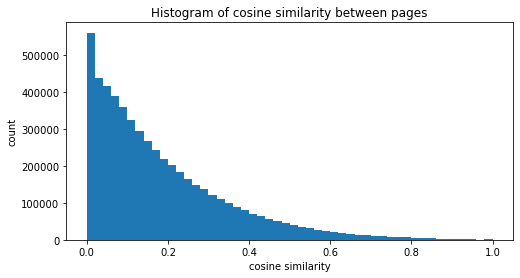

95.0% of the distances between pages are below:  0.5186746333908997


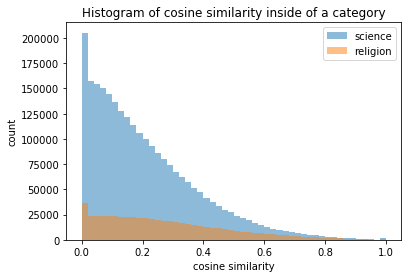

95.0% of the distances between religion pages are below:  0.6752008322039807
95.0% of the distances between science pages are below:  0.5564567993086181


In [25]:
# histogram of cosine similarity

plt.figure(1, figsize=(8, 4))
plt.title("Histogram of cosine similarity between pages")
plt.hist(distances .flatten(),bins =50);
plt.xlabel('cosine similarity')
plt.ylabel('count')
plt.show()

quantile = 0.95
print(f"{quantile*100}% of the distances between pages are below: ", np.quantile(distances,quantile))

plt.title("Histogram of cosine similarity inside of a category")
plt.hist(distances_science.flatten(), bins = 50 , alpha=0.5, label='science')
plt.hist(distances_religion.flatten(), bins = 50, alpha=0.5, label='religion')
plt.xlabel('cosine similarity')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.show()

print(f"{quantile*100}% of the distances between religion pages are below: ",  np.quantile(distances_religion,quantile))
print(f"{quantile*100}% of the distances between science pages are below: ", np.quantile(distances_science,quantile))


We notice a heavy-tailed distribution. The similarity between papers is hence concentrated around 0 and 0.2 between most papers but there are some rare papers with very high cosine similarity scores.

Let's examine an example of distance distribution for one religon paper.

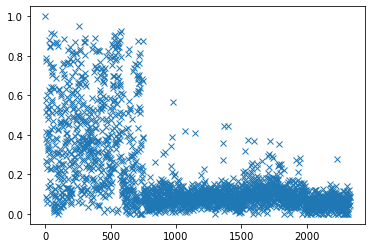

In [26]:
plt.plot(distances[0],'x')

Let's examine an example of distance distribution for one scientific paper

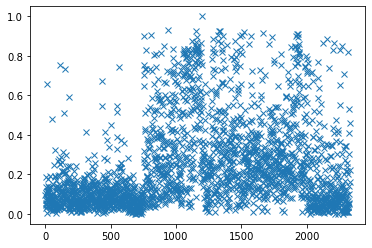

In [27]:
plt.plot(distances[1200],'x')

### 2. Adjacency Matrix

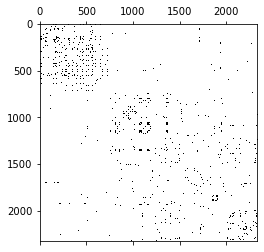

In [28]:
# according to previous part approximatly 95% of the articles of given category have cosine distances above 0.6
# we will keep this value as a threshold, distances that are below 0.6, won't be taken in account in our adjacency matrix
adjacency = matrixu.article_sim_th(0.65,distances, weight=True)

plt.spy(adjacency)
plt.show()

## B. Exploring graph properties

### 1. General features

In [29]:
# building a graph using the normalized distances
graph = nx.from_numpy_matrix(adjacency)

# assessing the giant component size
giant_feature = max(nx.connected_component_subgraphs(graph), key=len)
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

print("average clustering coefficient of our graph:",nx.average_clustering(graph))

The giant component of the feature graph has 2298 nodes and 50117 edges.
average clustering coefficient of our graph: 0.53445162646999


In [30]:
#study the connected components
graphs = list(nx.connected_component_subgraphs(graph))
for i in range(0,len(graphs)):
    print("subgraph nb ", i, "nb of nodes:",len(graphs[i].degree))

subgraph nb  0 nb of nodes: 2298
subgraph nb  1 nb of nodes: 1
subgraph nb  2 nb of nodes: 1
subgraph nb  3 nb of nodes: 1
subgraph nb  4 nb of nodes: 1
subgraph nb  5 nb of nodes: 2
subgraph nb  6 nb of nodes: 1
subgraph nb  7 nb of nodes: 1
subgraph nb  8 nb of nodes: 1
subgraph nb  9 nb of nodes: 1
subgraph nb  10 nb of nodes: 1
subgraph nb  11 nb of nodes: 1
subgraph nb  12 nb of nodes: 1
subgraph nb  13 nb of nodes: 1
subgraph nb  14 nb of nodes: 1
subgraph nb  15 nb of nodes: 1
subgraph nb  16 nb of nodes: 1
subgraph nb  17 nb of nodes: 1
subgraph nb  18 nb of nodes: 1
subgraph nb  19 nb of nodes: 1
subgraph nb  20 nb of nodes: 1
subgraph nb  21 nb of nodes: 1
subgraph nb  22 nb of nodes: 1
subgraph nb  23 nb of nodes: 1
subgraph nb  24 nb of nodes: 1
subgraph nb  25 nb of nodes: 1
subgraph nb  26 nb of nodes: 1
subgraph nb  27 nb of nodes: 1
subgraph nb  28 nb of nodes: 1
subgraph nb  29 nb of nodes: 1
subgraph nb  30 nb of nodes: 1
subgraph nb  31 nb of nodes: 1


The graph contains one giant component, one small component composed of two nodes and 16 other components made up of one isolated node each.

In [31]:
nodes_small_comp = list(graphs[5].nodes())

#for curiosity, articles linked in the small component
for node in nodes_small_comp:
     print(features.index[node])

Tadibya
Five Billion Years of Change


### 2. Degree distribution

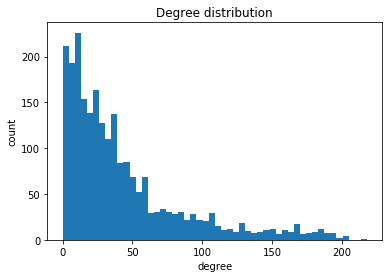

In [32]:
plt.title("Degree distribution")
degrees = [d for (i,d) in graph.degree()]
plt.hist(degrees,bins = 50);
plt.xlabel('degree')
plt.ylabel('count')
plt.show()

The distribution of the degree follows a power law, hence the garph corresponds to a scale free network.

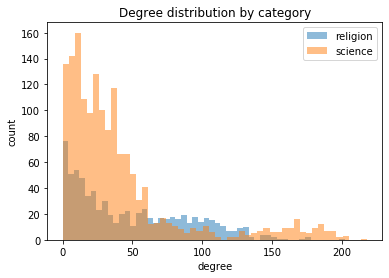

In [33]:
#observe articles with highest degree

list_degree = list(graph.degree)
degree_religion = []
degree_science = []
data= []

for node in list_degree:
    if(node[0]<=751):
        category = "religion"
        degree_religion.append(node[1])
    else:
        category = "science"
        degree_science.append(node[1])
    article_name = features.index[node[0]]
    degree = node[1]
    
    data.append([article_name,category,degree])
    
df = pd.DataFrame(data, columns = ['Article Name', 'Category','Degree'])

plt.title("Degree distribution by category")
plt.hist(degree_religion, bins = 50 , alpha=0.5, label='religion')
plt.hist(degree_science, bins = 50, alpha=0.5, label='science')
plt.xlabel('degree')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.show()

### 3. Articles with highest and lowest degrees

In [34]:
#articles with highest degree
df.sort_values(by=['Degree'],ascending=False)[:12]

,Article Name,Category,Degree
939,"Little Science, Big Science",science,218
1200,Fringe science,science,204
1318,Logology (science),science,203
1667,Junk science,science,202
751,Science,religion,202
1332,Post-normal science,science,197
1333,Postnormal times,science,197
1505,Pseudoscience,science,195
1520,Antiscience,science,195
1282,Scientometrics,science,194


# III. Exploiting the graph

## A. Preparing graph for exploitation

We start off by removing the nodes that are not connected.

In [35]:
removed_df, distances_wo, tf_idf_wo, labels_df_wo = matrixu.remove_noconnected(adjacency, distances, tf_idf, labels_df)
removed_df

,article,words,label,words_string
130,Buber-Rosenzweig-Medal,"[annual, prize, awarded, since, deutscher, koo...",0,annual prize awarded since deutscher koordinie...
239,Free Thought and Official Propaganda,"[free, thought, official, propaganda, speech, ...",0,free thought official propaganda speech subseq...
252,Marketplace of ideas,"[marketplace, ideas, rationale, freedom, expre...",0,marketplace ideas rationale freedom expression...
353,Siladhara Order,"[siladhara, order, theravada, buddhist, female...",0,siladhara order theravada buddhist female mona...
367,Secular paganism,"[secular, paganism, humanistic, paganism, upho...",0,secular paganism humanistic paganism upholds v...
395,Niraj Jain,"[pandit, niraj, jain, october, march, scholar,...",0,pandit niraj jain october march scholar jainis...
457,Animatism,"[animat, artificial, animals, contraction, ani...",0,animat artificial animals contraction animal m...
506,Chester Ronning Centre for the Study of Religi...,"[chester, ronning, centre, study, religion, pu...",0,chester ronning centre study religion public l...
585,Chakravarti (Sanskrit term),"[indian, religions, chakravarti, sanskrit, cak...",0,indian religions chakravarti sanskrit cakravar...
696,Prorrhesis,"[part, eleusinian, mysteries, prorrhesis, offi...",0,part eleusinian mysteries prorrhesis official ...


In [36]:
mean_nb_words_removed = len(removed_df["words"].explode())/len(removed_df)
print("The mean number of words of the removed articles are " + str(mean_nb_words_removed))

The mean number of words of the removed articles are 187.53333333333333


In [37]:
views_df_removed = views_df.merge(removed_df, on = "article")
mean_nb_views_removed = views_df_removed["views"].sum()/len(views_df_removed)
print("The mean number of views of these articles are " + str(mean_nb_views_removed) + " per month")

The mean number of views of these articles are 818.5666666666667 per month


In [38]:
mean_nb_words = len(words_df_reduced["words"].explode())/len(words_df_reduced)
print("The mean number of words of the articles are " + str(mean_nb_words))

The mean number of words of the articles are 782.8094420600859


In [39]:
mean_nb_views = views_df["views"].sum()/len(views_df)
print("The mean number of views of the articles are " + str(mean_nb_views) + " per month")

The mean number of views of the articles are 5970.546862265689 per month


The removed articles belong to the religon and science articles with approximatively the same proportion which hence reduces the chances of possible article removal bias. Furthermore, these articles tend to be mostly short articles. We may hence claim that these articles are stub and that they need more expansion and devolepment. The mean number of views for the removed articles is significantly smaller than for the total articles, confirming our suspicion about these articles being stubs. 

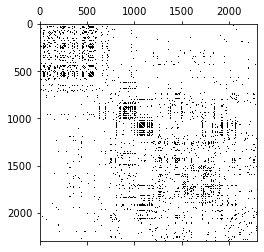

In [40]:
adjacency_wo = matrixu.article_sim_th(0.50,distances_wo, weight=True)

plt.spy(adjacency_wo)
plt.show()

## B. Visualizing the graph obtained

We proceed to visualize the graph to see if we can notice any clusters of articles and to see what the graph resembles.

In [41]:
visu = VisUtils()

### 1. Laplacian Eigenmaps

Text(0.5, 1.0, 'Graph of Wikipedia Science and Religion articles (done using Laplacian Eigenmaps)')

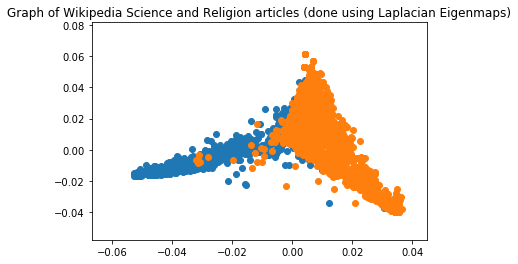

In [42]:
laplacian = matrixu.compute_laplacian(adjacency_wo, normalize=True)
eigenvalues, eigenvectors = matrixu.spectral_decomposition(np.nan_to_num(laplacian)) 
twoD_embeddings = (eigenvectors[:,1:3])
plt.scatter(twoD_embeddings[labels_df_wo[labels_df_wo["label"] == 0].index,0], twoD_embeddings[labels_df_wo[labels_df_wo["label"] == 0].index,1], label=1)
plt.scatter(twoD_embeddings[labels_df_wo[labels_df_wo["label"] == 1].index,0], twoD_embeddings[labels_df_wo[labels_df_wo["label"] == 1].index,1], label=2)
plt.title('Graph of Wikipedia Science and Religion articles (done using Laplacian Eigenmaps)')

### 2. t-SNE

In [43]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2)
x_embed = tsne.fit_transform(distances_wo)

Text(0.5, 1.0, 'Graph of Wikipedia Science and Religion articles (done using tSN-E)')

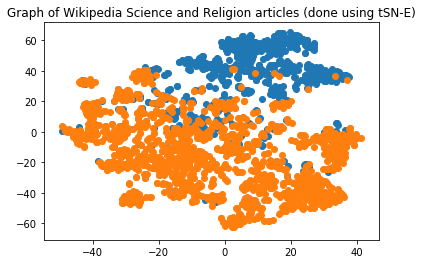

In [44]:
plt.scatter(x_embed[labels_df_wo[labels_df_wo["label"] == 0].index,0], x_embed[labels_df_wo[labels_df_wo["label"] == 0].index,1], label=1)
plt.scatter(x_embed[labels_df_wo[labels_df_wo["label"] == 1].index,0], x_embed[labels_df_wo[labels_df_wo["label"] == 1].index,1], label=2)
plt.title('Graph of Wikipedia Science and Religion articles (done using tSN-E)')

Despite some overlap, we can see in both plots (Laplacian Eigenmaps and t-SNE) that there is a clear difference among the articles belonging to science (orange) and the articles belonging to religion (blue).

## C. Machine Learning

### 1. Unsupervised learning

We will first apply some unsupervised learning on our graph. This will mostly correspond to clustering.

#### a. Eigengaps Heuristic

In order to apply clustering to our graph, we need to find an optimal number of clusters $K$. To this end, we follow the eigengap heuristic. It states that the optimal $K$ corresponds to the index of the eigenvalue $\lambda_{K}$ such that the difference $\lambda_{K} - \lambda_{K-1}$ is the biggest difference between eigenvalues.

Text(0.5, 1.0, 'Eigenvalues $L_{comb}$')

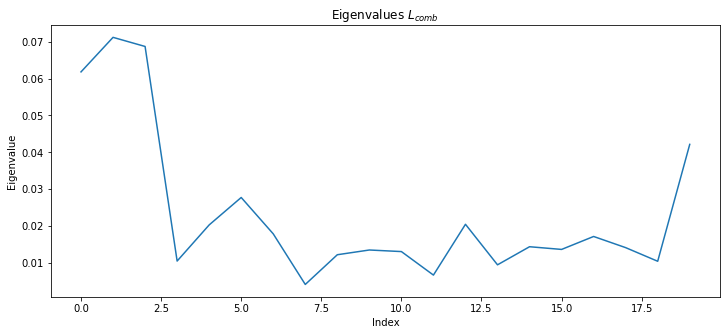

In [45]:
laplacian = matrixu.compute_laplacian(adjacency_wo, normalize = True)
eigenvalues, eigenvectors = matrixu.spectral_decomposition(laplacian)
eigengaps = eigenvalues[1:] - eigenvalues[:-1]
plt.figure(figsize=(12,5))
plt.plot(eigengaps[0:20])
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{comb}$')

We can see that in our case, it is not completely clear but that we may say that $K = 2$ seems like a good candidate.

#### b. Spectral Clustering

In [43]:
class SpectralClustering():
    def __init__(self, n_classes: int, normalize: bool):
        self.n_classes = n_classes
        self.normalize = normalize
        self.laplacian = None
        self.e = None
        self.U = None
        self.clustering_method =  None
        
    def fit_predict(self, adjacency):
        """
        Function to fit and predict a given adjacency matrix to spectral clustering.
        Arguments:
        self
        adjacency - an adjacency matrix
        Returns:
        y_pred (np.ndarray): cluster assignments.
        """
        laplacian = matrixu.compute_laplacian(adjacency, self.normalize)
        lamb, U = matrixu.spectral_decomposition(laplacian)
        Y = U[:,0:self.n_classes].real
        kmeans = KMeans(n_clusters = self.n_classes).fit(Y)
        y_pred =  kmeans.predict(Y)
        centers = kmeans.cluster_centers_
        return y_pred, centers
    
    def make_clusters(self, adjacency, tf_idf_wo, df):
        """
        Function that make self.n_classes clusters from the spectral clustering technique
        Arguments:
        self
        adjacency - the adjacency matrix of the selected articles
        tf_idf_wo - the tf-idf score from the selected articles
        df : the index and sequence of words from the selected articles
        Returns : 
        clusters_df - Will give detailled informations about each clusters:
        The most revelant article in term of content, the longest and most viewed articles of the clusters,
        the 10 most revelant words of the clusters (based on their tf-idf scores), 
        the percentage of articles that was initially fetch from the wikipedia religion or science categories,
        the average clustering of the hyperlink graph of the cluster based on the hyperlinks whithin the cluster.
        y_pred - the new labelling of each articles indices based on the clusters computed.
        """
        y_pred, centers = self.fit_predict(adjacency)
        y_pred = pd.DataFrame(y_pred, columns = ["label"])
        laplacian = matrixu.compute_laplacian(adjacency, True)
        lamb, U = matrixu.spectral_decomposition(laplacian)
        Y = U[:,0:self.n_classes].real
        clusters_df = pd.DataFrame([tf_idf_wo.columns.values[np.argsort(-(Y @ centers.T).T@tf_idf_wo.values, 1)[i][:10]] for i in range(self.n_classes)]).T
        clusters_df.index = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        clusters_df.loc[0] = tf_idf_wo.index[np.argmax(Y @ centers.T, 0)]
        clusters_df.loc[1] = [df.merge(tf_idf_wo.iloc[y_pred[y_pred["label"] == i].index], on = "article").explode("words").groupby(["article"]).count().sort_values(by = ["words"], ascending = False).index[0] for i in range(self.n_classes)]
        clusters_df.loc[2] = [views_df.merge(tf_idf_wo.iloc[y_pred[y_pred["label"] == i].index], on = "article").sort_values(by = ["views"], ascending = False).iloc[0]["article"] for i in range(self.n_classes)]
        clusters_df.loc[13] = [len(y_pred[y_pred["label"] == i]) for i in range(self.n_classes)]
        clusters_df.loc[14] = [100 - (labels_df_wo.iloc[y_pred[y_pred["label"] == i].index].sum().values[-1:]*100 / len(y_pred[y_pred["label"] == i])) for i in range(self.n_classes)]
        clusters_df.loc[15] = [labels_df_wo.iloc[y_pred[y_pred["label"] == i].index].sum().values[-1:]*100 / len(y_pred[y_pred["label"] == i]) for i in range(self.n_classes)]
        clustering = [0 for  i in range(self.n_classes)]
        for i in range(self.n_classes):
            graph = nx.from_numpy_matrix(hyperlinks[views_df.reset_index().merge(tf_idf_wo.iloc[y_pred[y_pred["label"] == i].index], on = "article").index,:][:,views_df.reset_index().merge(tf_idf_wo.iloc[y_pred[y_pred["label"] == i].index], on = "article").index])
            clustering[i] = nx.average_clustering(graph)
        clusters_df.loc[16] = clustering
        clusters_df.sort_index(inplace=True)
        clusters_df.index = ["Most relevant article", "Longest article", "Most viewed article", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "Number of articles","Percentage of religion article", "Percentage of science articles", "Average clustering of the hyperlinks matrix"]
        clusters_df.sort_values(by = ["Number of articles"], axis = 1, inplace = True)
        return clusters_df, y_pred

In [44]:
spectral_clustering = SpectralClustering(n_classes=2, normalize=True)
clusters_df, y_pred = spectral_clustering.make_clusters(adjacency_wo, tf_idf_wo, words_df_reduced)
clusters_df

,1,0
Most relevant article,Criticism of religion,Logology (science)
Longest article,Religious symbolism in the United States military,Well-being contributing factors
Most viewed article,List of religious populations,Myers–Briggs Type Indicator
1,religion,science
2,religious,scientific
3,god,research
4,church,also
5,religions,technology
6,christian,book
7,also,university


We can distinguish two clusters:

* One cluster with approximatively only religion articles.
* The other one with approximatively all the science articles plus a part of religion articles.

What is the particularity of these religion articles which were classified with the science articles? Let's apply some clustering to them to take a closer look at their topics.

In [45]:
new_interest_df = y_pred[y_pred["label"] == 0].merge(labels_df_wo[labels_df_wo["label"] == 0], left_index = True, right_index = True)
new_df = words_df_reduced.merge(new_interest_df, left_index = True, right_on = "index")
new_df.head(10)

,article,words,label,words_string,label_x,index,label_y
10,Center for Inquiry,"[center, inquiry, cfi, nonprofit, advocacy, or...",0,center inquiry cfi nonprofit advocacy organiza...,0,10,0
11,Coexist (image),"[coexist, image, often, styled, coexist, coexi...",0,coexist image often styled coexist coexist ima...,0,11,0
13,Joseph-Aurélien Cornet,"[cornet, born, may, bièvre, died, january, cin...",0,cornet born may bièvre died january ciney belg...,0,13,0
14,Đạo Mẫu,"[đạo, mẫu, vietnamese, ɗâːwˀ, 道母, worship, mot...",0,đạo mẫu vietnamese ɗâːwˀ 道母 worship mother god...,0,14,0
23,England's Happiness in the Crowning of William...,"[england, happiness, crowning, william, mary, ...",0,england happiness crowning william mary englis...,0,23,0
26,Faith literate,"[faith, literate, describes, ability, individu...",0,faith literate describes ability individual be...,0,26,0
28,Golden Rule,"[golden, rule, principle, treating, others, wa...",0,golden rule principle treating others want tre...,0,28,0
33,Intersex people and religion,"[intersex, people, born, sex, characteristics,...",0,intersex people born sex characteristics chrom...,0,33,0
38,Mesopotamian divination,"[mesopotamian, divination, divination, within,...",0,mesopotamian divination divination within meso...,0,38,0
45,Pathinettampadi,"[pathinettampadi, malayalam, divine, steps, fa...",0,pathinettampadi malayalam divine steps famed s...,0,45,0


In [46]:
def entire_pipeline(df, nb_clusters=2):
    """
    Function to apply the entire coding pipeline to a given dataframe
    Arguments:
    df - dataframe
    nb_clusters - number of clusters for the clustering
    Returns:
    clusters_df - the dataframe containing the clustered data with the detailled informations
    y_pred - the new labeling of the articles based on the clustering
    important_words_df - the most relevant words based on tf-idf score
    removed_df - the articles removed because of no connection with the other articles
    new_labels_df_wo - the binary labeling from which category the article was fetch without the removing articles
    tf_idf_wo - the tf-idf score for all the articles, which will serve as our features
    """
    tf_idf = nlpu.TF_IDF(df, 50)
    features = tf_idf
    important_words_df = pd.DataFrame(tf_idf.sum(axis=0, numeric_only=True).sort_values(ascending = False),\
                                  columns=['tfidf'])
    features_a = np.array(features)
    distances = matrixu.cosine_distances(matrixu, features_a)
    adjacency = matrixu.article_sim_th(0.60,distances, weight=True)
    removed_df, distances_wo, tf_idf_wo, new_labels_df_wo = matrixu.remove_noconnected(adjacency, distances, tf_idf, labels_df_wo)
    adjacency_wo = matrixu.article_sim_th(0.50,distances_wo, weight=True)
    laplacian = matrixu.compute_laplacian(adjacency_wo, normalize = True)
    eigenvalues, eigenvectors = matrixu.spectral_decomposition(laplacian)
    plt.figure(figsize=(12,5))
    plt.plot(eigenvalues[0:20])
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue')
    plt.title('Eigenvalues $L_{comb}$')
    spectral_clustering = SpectralClustering(n_classes=nb_clusters, normalize=True)
    clusters_df, y_pred = spectral_clustering.make_clusters(adjacency_wo, tf_idf_wo, new_df)
    return clusters_df, y_pred, important_words_df, removed_df, new_labels_df_wo, tf_idf_wo

,2,1,3,0,4
Most relevant article,Long Healing Prayer,Theosophy and literature,Lists of skepticism topics,Faith and Globalisation Initiative,Monty Python
Longest article,Bahá'í studies,Theosophy and music,List of Armenian Catholicoi of Cilicia,Center for Inquiry,Well-being contributing factors
Most viewed article,Salah times,King of Kings,List of angels in theology,Center for Inquiry,George Carlin
1,bahá,theosophical,list,university,one
2,prayer,retrieved,deities,testament,also
3,book,blavatsky,angel,faith,time
4,published,isbn,testament,center,would
5,faith,buddhism,see,new,people
6,studies,society,also,list,book
7,study,university,references,study,world


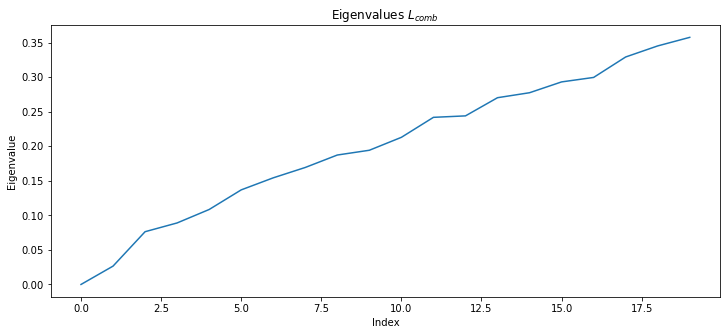

In [47]:
new_clusters_df, new_y_pred, new_important_words_df, new_removed, new_labels_df_wo, new_tf_idf_wo = entire_pipeline(new_df, 5)
new_clusters_df

We notice five major clusters
* One cluster includes the Baháʼí Faith, a religion from Haifa.
* One cluster contains the list of angels and topics in religion.
* One cluster contains articles which mostly correspond to theosophy which is a new religion movement launched by Helena Blavatsky.
* One cluster is about the foundation of research in science and religion.
* The final cluster represents philosophy and spirituality.

We observe that the first 3 clusters have very low clustering from their hyperlink matrix. This means that these articles are not connected among themselves via hyperlinks. This can stem from one of two different reasons. On one hand, the clustering might not be perfect and these articles might have not a lot in common (they are in fact the three clusters with the least number of articles which means that they are somewhat specific compared to bigger clusters). On the other hand, the hyperlinks might need to be improved to ensure that there are links between articles belonging to the same subject.

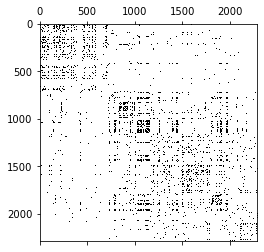

In [48]:
df = words_df_reduced.merge(pd.concat([removed_df, new_removed]), on = ["article","label","words_string"], how = "left", indicator=True)
df = df[df["_merge"]=='left_only'].drop(columns = ["words_y", "_merge"])
df.columns = ["article", "words", "label", "words_string"]
words = pd.concat([important_words_df, new_important_words_df]).index
final_features = nlpu.TF_IDF(df, 100, True, words.values)
features_a = np.array(final_features)
distances = matrixu.cosine_distances(matrixu, features_a)
final_adjacency = matrixu.article_sim_th(0.50,distances, weight=True)
plt.spy(final_adjacency)
plt.show()

In [49]:
df0 = pd.DataFrame(df[df["article"].isin(tf_idf_wo.iloc[y_pred[y_pred["label"] == 1].index].index)].index.values, columns = ["Index"])
df0["label"] = 0
df0["name"] = "This article is a religion related articles"
df1 = pd.DataFrame(df[df["article"].isin(tf_idf_wo.iloc[y_pred[y_pred["label"] == 0].index].index)].index.values, columns = ["Index"])
df1["label"] = 1
df1["name"] = "This article is a science related articles"
df2 = pd.DataFrame(df[df["article"].isin(new_tf_idf_wo.iloc[new_y_pred[new_y_pred["label"] == 2].index].index)].index.values, columns = ["Index"])
df2["label"] = 2
df2["name"] = "This article is a Bahaism related articles"
df3 = pd.DataFrame(df[df["article"].isin(new_tf_idf_wo.iloc[new_y_pred[new_y_pred["label"] == 3].index].index)].index.values, columns = ["Index"])
df3["label"] = 3
df3["name"] = "This article is a list in religion related articles"
df4 = pd.DataFrame(df[df["article"].isin(new_tf_idf_wo.iloc[new_y_pred[new_y_pred["label"] == 1].index].index)].index.values, columns = ["Index"])
df4["label"] = 4
df4["name"] = "This article is a theosophy related articles"
df5 = pd.DataFrame(df[df["article"].isin(new_tf_idf_wo.iloc[new_y_pred[new_y_pred["label"] == 0].index].index)].index.values, columns = ["Index"])
df5["label"] = 5
df5["name"] = "This article is a research in religion related articles" 
df6 = pd.DataFrame(df[df["article"].isin(new_tf_idf_wo.iloc[new_y_pred[new_y_pred["label"] == 4].index].index)].index.values, columns = ["Index"])
df6["label"] = 6
df6["name"] = "This article is a spirituality, psychology and comedy about religion related articles"
df7 = pd.DataFrame(removed_df.index.values, columns = ["Index"])
df7["label"] = 7
df7["name"] = "This article is either not connected to religion or science domains or a stub"
labels = pd.concat([df0, df1, df2, df3, df4, df5, df6]).drop_duplicates(subset = "Index", keep = "last").sort_values(by = ['Index'])

We create seven different cluster of articles from the clustering we have found through spectral clustering.

### 2. Supervised Learning

Given the previous labeling made through spectral clustering, we will train a Laplacian Polynomial model for graph filtering.

In [50]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from dgl import DGLGraph
import dgl.function as fn

np.random.seed(0)
torch.manual_seed(1)

In [51]:
class LaplacianPolynomial(nn.Module):
    def __init__(self,
                 in_feats: int,
                 out_feats: int,
                 k: int,
                 dropout_prob: float,
                 norm=True):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        self._norm = norm
        # Contains the weights learned by the Laplacian polynomial
        self.pol_weights = nn.Parameter(torch.Tensor(self._k + 1))
        # Contains the weights learned by the logistic regression (without bias)
        self.logr_weights = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.manual_seed(0)
        torch.nn.init.xavier_uniform_(self.logr_weights, gain=0.01)
        torch.nn.init.normal_(self.pol_weights, mean=0.0, std=1e-3)

    def forward(self, graph, feat):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.

        Parameters
        ----------
        graph (DGLGraph) : The graph.
        feat (torch.Tensor): The input feature

        Returns
        -------
        (torch.Tensor) The output feature
        """
        feat = self.dropout(feat)
        graph = graph.local_var()
        
        # D^(-1/2)
        norm = torch.pow(graph.in_degrees().float().clamp(min=1), -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, self.logr_weights)

        result = self.pol_weights[0] * feat.clone()

        for i in range(1, self._k + 1):
            old_feat = feat.clone()
            if self._norm:
                feat = feat * norm
            graph.ndata['h'] = feat
            # Feat is not modified in place
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            if self._norm:
                graph.ndata['h'] = graph.ndata['h'] * norm

            feat = old_feat - graph.ndata['h']
            result += self.pol_weights[i] * feat

        return result

    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        return summary.format(**self.__dict__)

In [52]:
def train(model, g, features, labels, loss_fcn, train_mask, optimizer):
    """
    Train the model
    Arguments : 
    model 
    g - the graph
    features - the tf-idf weights
    labels - the true labels
    loss-fcn - the loss function
    train_mask - the indices of the articles that were in the training set
    optimizer
    Return :
    The loss linked to false prediction
    """
    model.train()  # Activate dropout
    
    logits = model(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def evaluate(model, g, features, labels, mask):
    """
    Evaluate the model
    Arguments : 
    model 
    g - the graph
    features - the tf-idf weights
    labels - the true labels
    mask - the indices of the selected articles to test
    Return : 
    The accuracy of the model
    """
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)
       
def test_articles(model, g, features, mask):
    """
    Test the model to articles and make a prediction
    Arguments : 
    model 
    g - the graph
    features - the tf-idf weights
    mask - the indices of the selected articles to test
    Return : 
    The classification for the articles
    """
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask] 
        _, indices = torch.max(logits, dim=1)
        return indices
    
def make_predictions(list_articles, stop_words, df, words):
    """
    Make a prediction on the class for new articles and create a DataFrame for it
    Arguments : 
    list_articles - the list of new articles wanting to make a prediction 
    stop_words
    df - The articles for which the model was computed
    words - our selected list of words to calculate the tf-idf score
    Return : 
    The classification for the new articles
    """
    test_df = aquire.take_words(list_articles, stop_words, is_title = True)
    predict_df = pd.concat([df[["article", "words"]],test_df])
    features_final = nlpu.TF_IDF(predict_df, 100, True, words.values)
    features_a = np.array(features_final)
    distances = matrixu.cosine_distances(matrixu, features_a)
    adjacency = matrixu.article_sim_th(0.75,distances, weight=True)
    removed_df, distances_wo, tf_idf_wo, new_labels_df_wo = matrixu.remove_noconnected(adjacency, distances, features_final, labels_df_wo, True, predict_df)
    
    if(len(list(set(removed_df["article"].tolist()).intersection(list_articles))) != 0):
        idx = [list_articles.index(list(set(removed_df["article"].tolist()).intersection(list_articles))[j]) for j in range(len(list(set(removed_df["article"].tolist()).intersection(list_articles))))]
        
        
    adjacency = matrixu.article_sim_th(0.50,distances, weight=True)
    graph = nx.from_numpy_array(adjacency)
    graph = DGLGraph(graph)
    features_ = torch.FloatTensor(features_a)
    mask1 = np.zeros((len(df)))
    mask2 = np.ones((len(list_articles)))
    mask = np.concatenate((mask1,mask2))
    mask = torch.BoolTensor(mask)
    results = test_articles(model, graph, features_, mask).tolist()
    class_df = pd.DataFrame(np.column_stack((list_articles,\
                                         [labels[labels["label"] == results[i]]["name"].drop_duplicates().values[0] for i in range(len(list_articles))])),\
                                           columns = ["Name of the Article", "Prediction"])
    if (len(list(set(removed_df["article"].tolist()).intersection(list_articles))) != 0):
        for k in range(len(idx)):
            class_df.iloc[idx[k]] = [list_articles[idx[k]], "This article is either not connected to religion or science domains or a stub"]
            
    class_df = pd.DataFrame(class_df)
    return class_df,

#### a. Binary classification (Science vs Religion)

This first part will consist of a classification between articles from science and religion.

In [53]:
from sklearn.model_selection import train_test_split
x1, x2, y1, y2, idx1, idx2 = train_test_split(
    final_adjacency, new_labels_df_wo['label'], range(final_adjacency.shape[1]), test_size=0.4)
x3, x4, y3, y4, idx3, idx4 = train_test_split(
    x2, y2, idx2, test_size=0.5)

In [54]:
train_df = pd.DataFrame(np.column_stack((idx1, np.ones(len(idx1)).T)), columns = ['idx', 'indices'])
train_ = new_labels_df_wo.merge(train_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)
val_df = pd.DataFrame(np.column_stack((idx3, np.ones(len(idx3)).T)), columns = ['idx', 'indices'])
val_ = new_labels_df_wo.merge(val_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)
test_df = pd.DataFrame(np.column_stack((idx4, np.ones(len(idx4)).T)), columns = ['idx', 'indices'])
test_ = new_labels_df_wo.merge(val_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)

In [55]:
in_feats = final_features.shape[1] 
n_classes = 2
pol_order = 3
lr = 0.2
weight_decay = 5e-6
n_epochs = 100
p_dropout = 0.8
features_ = torch.FloatTensor(final_features.values) 
final_labels = torch.LongTensor(new_labels_df_wo['label'].values) 
train_mask = torch.BoolTensor(train_['indices'].values)
val_mask = torch.BoolTensor(val_['indices'].values)
test_mask = torch.BoolTensor(test_['indices'].values)

In [56]:
model = LaplacianPolynomial(in_feats, n_classes, pol_order, p_dropout)

graph_nx = nx.from_numpy_matrix(final_adjacency)
graph = DGLGraph(graph_nx)

loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    if epoch >= 3:
        t0 = time.time()
    loss = train(model, graph, features_, final_labels, loss_fcn, train_mask, optimizer)

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, graph, features_, final_labels, val_mask)
    print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.4f} | Val Accuracy {:.4f}". format(
            epoch, np.mean(dur), loss.item(), acc))

print()
acc = evaluate(model, graph, features_, final_labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Time(s) nan | Train Loss 0.6932 | Val Accuracy 0.4214
Epoch 00001 | Time(s) nan | Train Loss 0.7133 | Val Accuracy 0.4869
Epoch 00002 | Time(s) nan | Train Loss 0.6939 | Val Accuracy 0.4476
Epoch 00003 | Time(s) 0.0118 | Train Loss 0.6988 | Val Accuracy 0.4323
Epoch 00004 | Time(s) 0.0126 | Train Loss 0.7060 | Val Accuracy 0.4498
Epoch 00005 | Time(s) 0.0129 | Train Loss 0.7010 | Val Accuracy 0.6900
Epoch 00006 | Time(s) 0.0131 | Train Loss 0.6892 | Val Accuracy 0.8057
Epoch 00007 | Time(s) 0.0128 | Train Loss 0.6804 | Val Accuracy 0.8231
Epoch 00008 | Time(s) 0.0130 | Train Loss 0.6648 | Val Accuracy 0.8231
Epoch 00009 | Time(s) 0.0131 | Train Loss 0.6324 | Val Accuracy 0.8057
Epoch 00010 | Time(s) 0.0130 | Train Loss 0.5856 | Val Accuracy 0.8013
Epoch 00011 | Time(s) 0.0136 | Train Loss 0.5357 | Val Accuracy 0.8188
Epoch 00012 | Time(s) 0.0142 | Train Loss 0.4766 | Val Accuracy 0.8362
Epoch 00013 | Time(s) 0.0144 | Train Loss 0.4221 | Val Accuracy 0.8515
Epoch 00014 | T

#### b. Seven-class classification

Now in this second part, we will create a seven-category classifier using the classes found at the end of our unsupervised learning process (since there are no article that neither belong science nor religion in our set of articles).

In [57]:
from sklearn.model_selection import train_test_split
x1, x2, y1, y2, idx1, idx2 = train_test_split(
    final_adjacency, labels['label'], range(final_adjacency.shape[1]), test_size=0.4)
x3, x4, y3, y4, idx3, idx4 = train_test_split(
    x2, y2, idx2, test_size=0.5)

In [58]:
train_df = pd.DataFrame(np.column_stack((idx1, np.ones(len(idx1)).T)), columns = ['idx', 'indices'])
train_ = labels.merge(train_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)
val_df = pd.DataFrame(np.column_stack((idx3, np.ones(len(idx3)).T)), columns = ['idx', 'indices'])
val_ = labels.merge(val_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)
test_df = pd.DataFrame(np.column_stack((idx4, np.ones(len(idx4)).T)), columns = ['idx', 'indices'])
test_ = labels.merge(val_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)

In [59]:
in_feats = final_features.shape[1] 
n_classes = 8
pol_order = 3
lr = 0.2
weight_decay = 5e-6
n_epochs = 100
p_dropout = 0.8
features_ = torch.FloatTensor(final_features.values) 
final_labels = torch.LongTensor(labels['label'].values) 
train_mask = torch.BoolTensor(train_['indices'].values)
val_mask = torch.BoolTensor(val_['indices'].values)
test_mask = torch.BoolTensor(test_['indices'].values)

In [60]:
model = LaplacianPolynomial(in_feats, n_classes, pol_order, p_dropout)

graph_nx = nx.from_numpy_matrix(final_adjacency)
graph = DGLGraph(graph_nx)

loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    if epoch >= 3:
        t0 = time.time()
    loss = train(model, graph, features_, final_labels, loss_fcn, train_mask, optimizer)

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, graph, features_, final_labels, val_mask)
    print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.4f} | Val Accuracy {:.4f}". format(
            epoch, np.mean(dur), loss.item(), acc))

print()
acc = evaluate(model, graph, features_, final_labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

Epoch 00000 | Time(s) nan | Train Loss 2.0794 | Val Accuracy 0.4310
Epoch 00001 | Time(s) nan | Train Loss 2.0621 | Val Accuracy 0.7974
Epoch 00002 | Time(s) nan | Train Loss 1.9888 | Val Accuracy 0.8556
Epoch 00003 | Time(s) 0.0140 | Train Loss 1.8533 | Val Accuracy 0.8534
Epoch 00004 | Time(s) 0.0148 | Train Loss 1.6502 | Val Accuracy 0.8578
Epoch 00005 | Time(s) 0.0147 | Train Loss 1.4158 | Val Accuracy 0.8621
Epoch 00006 | Time(s) 0.0149 | Train Loss 1.1571 | Val Accuracy 0.8664
Epoch 00007 | Time(s) 0.0151 | Train Loss 0.9403 | Val Accuracy 0.8664
Epoch 00008 | Time(s) 0.0152 | Train Loss 0.7804 | Val Accuracy 0.8685
Epoch 00009 | Time(s) 0.0153 | Train Loss 0.6641 | Val Accuracy 0.8621
Epoch 00010 | Time(s) 0.0155 | Train Loss 0.6187 | Val Accuracy 0.8599
Epoch 00011 | Time(s) 0.0156 | Train Loss 0.5642 | Val Accuracy 0.8599
Epoch 00012 | Time(s) 0.0155 | Train Loss 0.5815 | Val Accuracy 0.8599
Epoch 00013 | Time(s) 0.0153 | Train Loss 0.5424 | Val Accuracy 0.8599
Epoch 00014 | T

#### c. Predicting classes for other wikipedia articles

Finally we will use the model to assess some differents articles picked from Wikipedia.

In [61]:
list_articles = ["God", "Network Science", "Gleti", "Helena Blavatsky", "Christian angelology", "Jesus", "Nabeul",\
                 "Lectures on Faith", "Principal component analysis", "Secular spirituality", "God in the Baháʼí Faith"]
predictions_df = make_predictions(list_articles, stop_words, df, words)

[====================] 99%

In [62]:
predictions_df[0]

,Name of the Article,Prediction
0,God,This article is a religion related articles
1,Network Science,This article is a science related articles
2,Gleti,This article is either not connected to religi...
3,Helena Blavatsky,This article is a theosophy related articles
4,Christian angelology,This article is a religion related articles
5,Jesus,This article is a religion related articles
6,Nabeul,This article is either not connected to religi...
7,Lectures on Faith,This article is a religion related articles
8,Principal component analysis,This article is a science related articles
9,Secular spirituality,This article is a religion related articles


The classification results seem to be correct in the sense that the classification categorizes each article in the correct class when choosing between religion and science. Furthermore, the article Gleti which a stub about a Moon Goddess and the article about Nabeul which is a city (both not connected to neither science nor religion) are correctly classified in the cluster which is made of stub non-connected articles. 

However, we would like that some articles be classified in a more specific cluster. For example, the article God in the Baháʼí Faith should ideally be classified in the Baha'i cluster. Our classifier puts it in the religious cluster which is correct but is not the best fit for it. Hence, there might be further improvements which we could bring to our subcategorization. On the other hane, the article about Helena Blavatsky, who is the founder of the Theosophy movement, is indeed correctly classify in the Theosophy cluster. Hence, our classifier works really well in that regard.